<a href="https://colab.research.google.com/github/SayanDas07/KWS-using-FewShotLearning/blob/main/FineTuneTFmodel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10+3 Classes classifiers .... samples of 13..+ FT... brining the TL model from drive07. file name TL(only 3keywords).ipynb

In [1]:
!nvidia-smi

Sun Jun 15 19:19:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-15 19:22:38--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.207, 142.251.10.207, 142.251.12.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  22.3MB/s    in 1m 41s  

2025-06-15 19:24:19 (22.9 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [5]:
!mkdir -p data_10_wav/data

In [6]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [7]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP/TL Variations /10+3Classes"

In [8]:
SAMPLES_TO_CONSIDER = 16000
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))


os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [9]:
print("frame_length:", frame_length)
print("hop_length:", hop_length)

frame_length: 512
hop_length: 256


In [10]:
new_keywords = ['tree', 'marvin', 'one']
keyword_list = ['off', 'left', 'down', 'up', 'go', 'on', 'stop', 'right', 'yes']
all_keywords = new_keywords + keyword_list
existing_keyword_index = {k: i for i, k in enumerate(keyword_list)}
new_keyword_index = {k: i + len(keyword_list) for i, k in enumerate(new_keywords)}
print(existing_keyword_index)
print(new_keyword_index)


{'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'right': 7, 'yes': 8}
{'tree': 9, 'marvin': 10, 'one': 11}


In [11]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [12]:
labels = []
log_mel_spectrograms = []

In [13]:
class_sample_counts = {kw: 0 for kw in all_keywords}

In [14]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    label = os.path.basename(dirpath)
    if label not in all_keywords:
        continue

    max_samples = 500 if label in new_keywords else 300
    print(f"\nProcessing: '{label}' (Max {max_samples} samples)")

    for f in filenames:
        file_path = os.path.join(dirpath, f)
        try:
            signal, _ = librosa.load(file_path, sr=16000)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        if len(signal) >= SAMPLES_TO_CONSIDER:
            signal = signal[:SAMPLES_TO_CONSIDER]
        else:
            signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

        signal = signal.astype(np.float32)
        windowed = signal * hamming_window(SAMPLES_TO_CONSIDER)

        mel_spec = librosa.feature.melspectrogram(
            y=windowed,
            sr=16000,
            n_mels=40,
            n_fft=frame_length,
            win_length=frame_length,
            hop_length=hop_length,
            center=False
        )

        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel_spectrograms.append(log_mel.T)

        if label in new_keywords:
            labels.append(new_keyword_index[label])
        else:
            labels.append(existing_keyword_index[label])

        class_sample_counts[label] += 1
        if class_sample_counts[label] >= max_samples:
            break


Processing: 'go' (Max 300 samples)

Processing: 'on' (Max 300 samples)

Processing: 'up' (Max 300 samples)

Processing: 'yes' (Max 300 samples)

Processing: 'stop' (Max 300 samples)

Processing: 'right' (Max 300 samples)

Processing: 'marvin' (Max 500 samples)

Processing: 'left' (Max 300 samples)

Processing: 'down' (Max 300 samples)

Processing: 'tree' (Max 500 samples)

Processing: 'one' (Max 500 samples)

Processing: 'off' (Max 300 samples)


In [15]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [16]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'))

In [17]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (4200, 61, 40)
y shape: (4200,)


In [18]:
from collections import Counter

# Combine both mappings: new + existing
keyword_to_index = {**existing_keyword_index, **new_keyword_index}
inv_label_map = {v: k for k, v in keyword_to_index.items()}

# Assuming `y` contains class indices (0–12)
label_counts = Counter(y)

for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")


off: 300 samples
left: 300 samples
down: 300 samples
up: 300 samples
go: 300 samples
on: 300 samples
stop: 300 samples
right: 300 samples
yes: 300 samples
tree: 500 samples
marvin: 500 samples
one: 500 samples


In [20]:
# Normalize
X = np.array([x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in X])

# ✅ Remove extra dims and reshape correctly
X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
y_cat = to_categorical(y, 12)

In [21]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (4200, 61, 40, 1)
y shape: (4200,)


In [22]:
tf_model = load_model("/content/CNN_TLMODE1.h5")

In [23]:
for i, layer in enumerate(tf_model.layers):
    print(i, layer.name)


0 input_layer
1 conv2d
2 relu1_1
3 conv2d_1
4 relu1_2
5 max_pooling2d
6 conv2d_3
7 re_lu
8 conv2d_4
9 conv2d_2
10 max_pooling2d_1
11 batch_normalization
12 add
13 res_relu_0
14 gap
15 fc1
16 dropout1
17 fc2
18 dropout2
19 fc3
20 dropout3
21 fc4
22 dropout4
23 fc5
24 dropout5
25 fc6
26 dropout6
27 fc7
28 dropout7
29 output


In [24]:
# Unfreeze from fc2 (index 17) onward
for i, layer in enumerate(tf_model.layers):
    layer.trainable = (i >= 17)


In [25]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.optimizers import Adam
optimizer = optimizers.Adam(learning_rate=1e-4)

In [28]:
tf_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5"
ckpt = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
tf_model.summary()

Model: "TransferModel3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 40,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_1 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 40,    │     25,632 │ relu1_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_2 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 20,    │          0 │ relu1_2[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 20,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 31, 20,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 20,    │    102,464 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_relu_0 (ReLU)   │ (None, 16, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ res_relu_0[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 512)       │     33,280 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 446,892 (1.70 MB)

 Trainable params: 231,052 (902.55 KB)

 Non-trainable params: 215,840 (843.12 KB)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [31]:
history = tf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, early_stop],
    verbose=1
)

Epoch 1/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1529 - loss: 16.3538
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1531 - loss: 16.0792 - val_accuracy: 0.2083 - val_loss: 4.6705
Epoch 2/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1577 - loss: 5.2491
Epoch 2: val_accuracy did not improve from 0.20833
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1579 - loss: 5.2322 - val_accuracy: 0.2083 - val_loss: 2.3132
Epoch 3/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1736 - loss: 2.8632
Epoch 3: val_accuracy improved from 0.20833 to 0.52024, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1745 - loss: 2.8546 - val_accuracy: 0.5202 - val_loss: 1.9227
Epoch 4/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2405 - loss: 2.2658
Epoch 4: val_accuracy improved from 0.52024 to 0.65357, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2420 - loss: 2.2608 - val_accuracy: 0.6536 - val_loss: 1.7229
Epoch 5/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3359 - loss: 2.0131
Epoch 5: val_accuracy improved from 0.65357 to 0.77143, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3366 - loss: 2.0103 - val_accuracy: 0.7714 - val_loss: 1.5400
Epoch 6/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4058 - loss: 1.8248
Epoch 6: val_accuracy improved from 0.77143 to 0.79643, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4064 - loss: 1.8222 - val_accuracy: 0.7964 - val_loss: 1.3512
Epoch 7/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4886 - loss: 1.6344
Epoch 7: val_accuracy improved from 0.79643 to 0.80238, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4884 - loss: 1.6330 - val_accuracy: 0.8024 - val_loss: 1.1592
Epoch 8/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5613 - loss: 1.4464
Epoch 8: val_accuracy improved from 0.80238 to 0.80952, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5616 - loss: 1.4439 - val_accuracy: 0.8095 - val_loss: 0.9697
Epoch 9/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5852 - loss: 1.2862
Epoch 9: val_accuracy improved from 0.80952 to 0.82619, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5854 - loss: 1.2840 - val_accuracy: 0.8262 - val_loss: 0.8095
Epoch 10/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6222 - loss: 1.1426
Epoch 10: val_accuracy improved from 0.82619 to 0.87857, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6227 - loss: 1.1410 - val_accuracy: 0.8786 - val_loss: 0.7010
Epoch 11/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6640 - loss: 1.0433
Epoch 11: val_accuracy improved from 0.87857 to 0.88929, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6641 - loss: 1.0413 - val_accuracy: 0.8893 - val_loss: 0.6296
Epoch 12/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6693 - loss: 0.9594
Epoch 12: val_accuracy did not improve from 0.88929
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6701 - loss: 0.9568 - val_accuracy: 0.8488 - val_loss: 0.5830
Epoch 13/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7044 - loss: 0.8503
Epoch 13: val_accuracy did not improve from 0.88929
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7035 - loss: 0.8508 - val_accuracy: 0.8881 - val_loss: 0.5395
Epoch 14/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7044 - loss: 0.8557
Epoch 14: val_accuracy improved from 0.88929 to 0.89286, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7046 - loss: 0.8543 - val_accuracy: 0.8929 - val_loss: 0.5114
Epoch 15/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7118 - loss: 0.7865
Epoch 15: val_accuracy improved from 0.89286 to 0.90357, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7126 - loss: 0.7850 - val_accuracy: 0.9036 - val_loss: 0.4813
Epoch 16/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7246 - loss: 0.7420
Epoch 16: val_accuracy did not improve from 0.90357
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7247 - loss: 0.7418 - val_accuracy: 0.9024 - val_loss: 0.4486
Epoch 17/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7534 - loss: 0.6926
Epoch 17: val_accuracy did not improve from 0.90357
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7534 - loss: 0.6921 - val_accuracy: 0.8702 - val_loss: 0.4259
Epoch 18/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7643 - loss: 0.6738
Epoch 18: val_accuracy did not improve from 0.90357
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7641 - loss: 0.6730 - val_accuracy: 0.8655 - val_loss: 0.4172
Epoch 19/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7747 - loss: 0.6538
Epoch 19: val_accuracy did n

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8460 - loss: 0.4596 - val_accuracy: 0.9095 - val_loss: 0.3275
Epoch 28/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8433 - loss: 0.4763
Epoch 28: val_accuracy did not improve from 0.90952
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8428 - loss: 0.4768 - val_accuracy: 0.9060 - val_loss: 0.3215
Epoch 29/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8506 - loss: 0.4262
Epoch 29: val_accuracy improved from 0.90952 to 0.91667, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8503 - loss: 0.4282 - val_accuracy: 0.9167 - val_loss: 0.3121
Epoch 30/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8423 - loss: 0.4723
Epoch 30: val_accuracy did not improve from 0.91667
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8425 - loss: 0.4717 - val_accuracy: 0.9155 - val_loss: 0.3083
Epoch 31/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8595 - loss: 0.4327
Epoch 31: val_accuracy improved from 0.91667 to 0.91905, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8592 - loss: 0.4323 - val_accuracy: 0.9190 - val_loss: 0.3008
Epoch 32/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.4115
Epoch 32: val_accuracy did not improve from 0.91905
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8586 - loss: 0.4123 - val_accuracy: 0.9190 - val_loss: 0.2961
Epoch 33/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8613 - loss: 0.4184
Epoch 33: val_accuracy improved from 0.91905 to 0.92143, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8613 - loss: 0.4178 - val_accuracy: 0.9214 - val_loss: 0.2906
Epoch 34/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8659 - loss: 0.4090
Epoch 34: val_accuracy improved from 0.92143 to 0.92381, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8660 - loss: 0.4092 - val_accuracy: 0.9238 - val_loss: 0.2861
Epoch 35/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8918 - loss: 0.3635
Epoch 35: val_accuracy did not improve from 0.92381
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8911 - loss: 0.3656 - val_accuracy: 0.9214 - val_loss: 0.2818
Epoch 36/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8635 - loss: 0.4199
Epoch 36: val_accuracy improved from 0.92381 to 0.92500, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8640 - loss: 0.4184 - val_accuracy: 0.9250 - val_loss: 0.2745
Epoch 37/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8794 - loss: 0.3708
Epoch 37: val_accuracy improved from 0.92500 to 0.92738, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8794 - loss: 0.3709 - val_accuracy: 0.9274 - val_loss: 0.2693
Epoch 38/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8828 - loss: 0.3631
Epoch 38: val_accuracy did not improve from 0.92738
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8826 - loss: 0.3635 - val_accuracy: 0.9238 - val_loss: 0.2676
Epoch 39/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8810 - loss: 0.3841
Epoch 39: val_accuracy did not improve from 0.92738
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8812 - loss: 0.3841 - val_accuracy: 0.9274 - val_loss: 0.2615
Epoch 40/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8718 - loss: 0.3734
Epoch 40: val_accuracy did not improve from 0.92738
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8730 - loss: 0.3715 - val_accuracy: 0.9238 - val_loss: 0.2616
Epoch 41/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8926 - loss: 0.3643
Epoch 41: val_accuracy did n

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8989 - loss: 0.3486 - val_accuracy: 0.9286 - val_loss: 0.2536
Epoch 44/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8885 - loss: 0.3826
Epoch 44: val_accuracy did not improve from 0.92857
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8889 - loss: 0.3810 - val_accuracy: 0.9274 - val_loss: 0.2512
Epoch 45/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9147 - loss: 0.3087
Epoch 45: val_accuracy did not improve from 0.92857
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9141 - loss: 0.3101 - val_accuracy: 0.9286 - val_loss: 0.2488
Epoch 46/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8957 - loss: 0.3525
Epoch 46: val_accuracy improved from 0.92857 to 0.93095, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8960 - loss: 0.3516 - val_accuracy: 0.9310 - val_loss: 0.2465
Epoch 47/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9072 - loss: 0.3377
Epoch 47: val_accuracy did not improve from 0.93095
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9070 - loss: 0.3375 - val_accuracy: 0.9286 - val_loss: 0.2478
Epoch 48/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9003 - loss: 0.3382
Epoch 48: val_accuracy improved from 0.93095 to 0.93214, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9004 - loss: 0.3379 - val_accuracy: 0.9321 - val_loss: 0.2459
Epoch 49/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9095 - loss: 0.3089
Epoch 49: val_accuracy did not improve from 0.93214
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9090 - loss: 0.3100 - val_accuracy: 0.9286 - val_loss: 0.2455
Epoch 50/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 0.3534
Epoch 50: val_accuracy did not improve from 0.93214
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9026 - loss: 0.3519 - val_accuracy: 0.9298 - val_loss: 0.2427


In [32]:
test_loss, test_accuracy = tf_model.evaluate(X_val, y_val, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9238 - loss: 0.2391
Test Accuracy: 0.93


In [33]:
loss, acc = tf_model.evaluate(X_val, y_val)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9238 - loss: 0.2391

Test Accuracy: 92.98%


In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


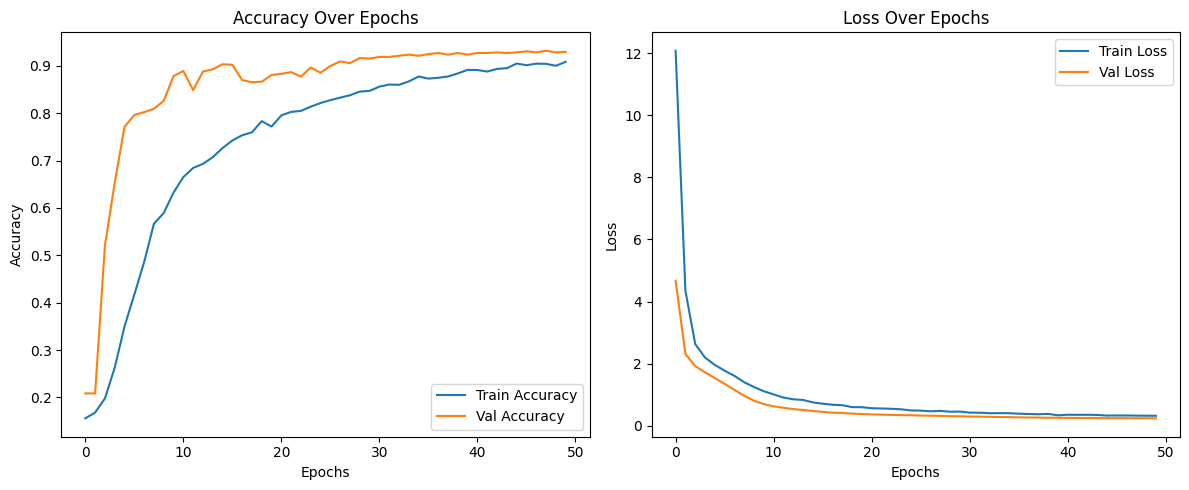

In [35]:
plot_training_history(history)

In [36]:
y_pred = tf_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [37]:
print(classification_report(y_true_classes, y_pred_classes, target_names=all_keywords))

              precision    recall  f1-score   support

        tree       0.97      0.97      0.97        60
      marvin       0.97      0.95      0.96        60
         one       1.00      0.95      0.97        60
         off       0.97      0.93      0.95        60
        left       0.95      0.93      0.94        60
        down       0.98      0.98      0.98        60
          up       0.98      0.97      0.97        60
          go       0.98      0.93      0.96        60
          on       1.00      0.98      0.99        60
        stop       0.86      0.92      0.89       100
       right       0.91      0.79      0.84       100
         yes       0.80      0.94      0.86       100

    accuracy                           0.93       840
   macro avg       0.95      0.94      0.94       840
weighted avg       0.93      0.93      0.93       840



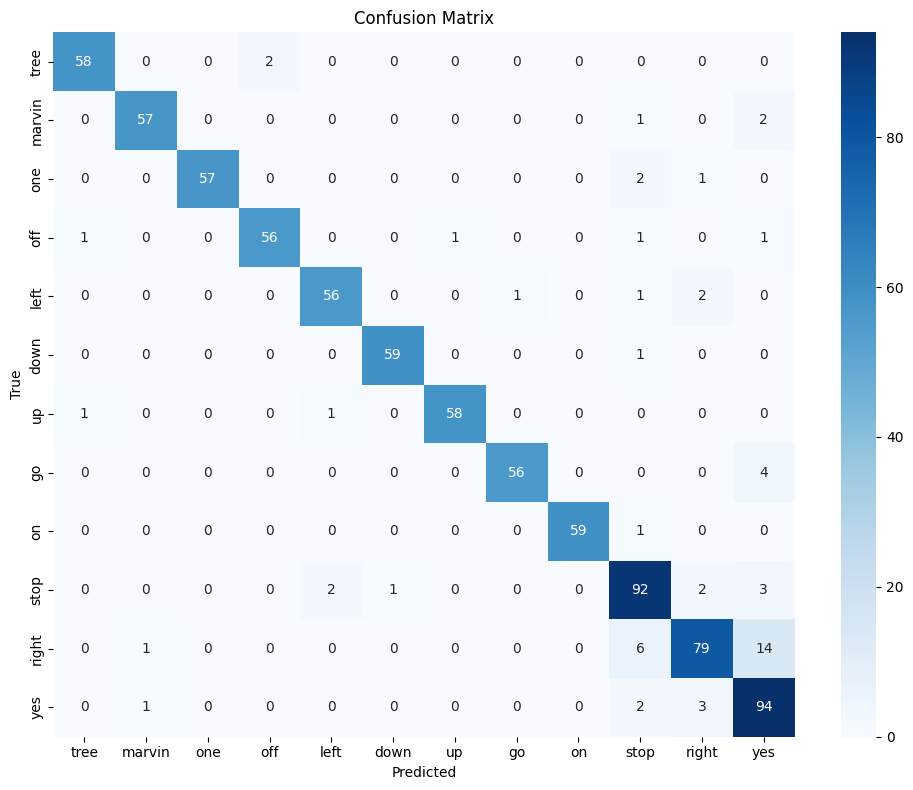

In [38]:
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_keywords, yticklabels=all_keywords)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
